In [1]:
# open up zsl name -> image map
from __future__ import division
from train_utils import dataset_loc
import utool as ut
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os.path import join, exists
import csv
from collections import defaultdict
from itertools import chain
%matplotlib inline
import random

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
# zsl raw data
identities_fn = join(dataset_loc,'Flukes/zooniverse-classifications/crc_ids.tsv')
zsl_img_id_map = defaultdict(lambda: set())
zsl_id_img_map = defaultdict(lambda: set())
with open(identities_fn,'r') as identities_f:
    reader = csv.DictReader(identities_f, 
                            fieldnames=['wb_context','wb_img_uuid','wb_enc_uuid','crc_id','fn'] ,
                            delimiter='\t')
    for row in reader:
        zsl_img_id_map[row['fn']].add(row['crc_id'])
        zsl_id_img_map[row['crc_id']].add(row['fn'])

In [3]:
# now let's get the Flukebook dataset in there
fb_id_img_map = ut.load_cPkl(join(dataset_loc, 'Flukes/Flukebook/fb_curv_good.pkl'))

[util_io] * load_cPkl(u'.../Flukebook/fb_curv_good.pkl')


In [4]:
fb_id_img_map = {k:v for k,v in fb_id_img_map.items() if k != '____'}

In [5]:
# Kosher question: is it ok to mix the ZSL and FB data? It's not super clear if the ids we have are distinct
# If not, we might end up with issues where there are false positives...

# Let's take a risk? (Otherwise I'd opt for the larger dataset, even if it's not perfect)
def make_dict_hist(dic):
    hist = defaultdict(lambda: 0)
    for id_ in dic:
        hist[len(dic[id_])] += 1
    return hist

zsl_id_img_hist = make_dict_hist(zsl_id_img_map)
fb_id_img_hist = make_dict_hist(fb_id_img_map)

In [6]:
zsl_id_img_hist.items()

[(1, 2038),
 (2, 530),
 (3, 268),
 (4, 156),
 (5, 74),
 (6, 49),
 (7, 30),
 (8, 22),
 (9, 16),
 (10, 9),
 (11, 6),
 (12, 5),
 (13, 3),
 (14, 4),
 (15, 3),
 (16, 3),
 (17, 3),
 (18, 1),
 (19, 2),
 (21, 2),
 (22, 2),
 (23, 3),
 (24, 1),
 (27, 1),
 (29, 1),
 (31, 1),
 (59, 1)]

In [7]:
fb_id_img_hist.items()

[(1, 432), (2, 358), (3, 53), (4, 16), (5, 3), (6, 3)]

In [8]:
# so there are two ways we can do this:
# 1) we can just give every image a unique id (after merging the sources) and have the batch loader figure out
# the pairings (we'd have to be able to make this fast)
# 2) we can preset the pairings, but this would prevent us from using a method like triplet loss
# we'll go w/option 1, and have the labels be ids

def prep_image_label(imgpath, indv_id, idprefix, size):
    # read in the image
    # we'll greyscale it so that if an indv has only greyscaled images that doesn't influence the network
    img = cv2.cvtColor(cv2.imread(imgpath),cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(img, size, cv2.INTER_LANCZOS4)
    return (resized_img, idprefix + indv_id)

def id_img_map_to_dset(id_img_map, idprefix, img_dir, size):
    # go through each id and add their images to a list
    final_list = []
    for id_ in id_img_map:
        for img in id_img_map[id_]:
            if not exists(join(img_dir, img)):
                continue
            final_list.append(prep_image_label(join(img_dir, img), id_, idprefix, size))
    return final_list

zsl_imgs_dir = join(dataset_loc, 'Flukes/CRC_combined constrained')
fb_imgs_dir = join(dataset_loc, 'Flukes/Flukebook/images')

In [9]:
zsl_dset = id_img_map_to_dset(zsl_id_img_map, 'zsl', zsl_imgs_dir, (256,256))

4630
zsl15133


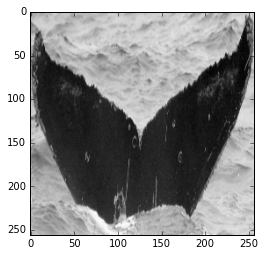

In [10]:
print(len(zsl_dset))
rand_ind = random.choice(range(len(zsl_dset)))
plt.gray()
plt.imshow(zsl_dset[rand_ind][0])
print(zsl_dset[rand_ind][1])

In [11]:
fb_dset = id_img_map_to_dset(fb_id_img_map, 'fb', fb_imgs_dir, (256,256))

1404
fb472235


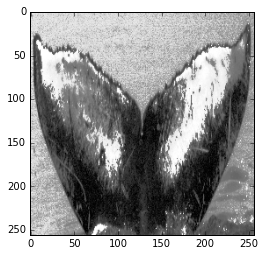

In [67]:
print(len(fb_dset))
rand_ind = random.choice(range(len(fb_dset)))
plt.gray()
hist_eq = cv2.equalizeHist(fb_dset[rand_ind][0])
plt.imshow(hist_eq)
print(fb_dset[rand_ind][1])

In [13]:
all_pairs = list(chain(zsl_dset, fb_dset))
all_imgs, all_ids = zip(*all_pairs)
all_imgs = np.stack(all_imgs, axis=0)
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

imgs, ids = shuffle(all_imgs, all_ids)
train_imgs, test_imgs, train_ids, test_ids = train_test_split(imgs, ids)
train_imgs, val_imgs, train_ids, val_ids = train_test_split(train_imgs, train_ids)

print(len(train_imgs))
print(len(train_ids))

3393
3393


In [14]:
from train_utils import save_dataset
saveto = 'fuckit_all_256'
save_dataset(join(dataset_loc,'Flukes/patches/%s' % saveto),
             (train_imgs, train_ids),
             (val_imgs, val_ids),
             (test_imgs, test_ids), grey=True)

[util_io] * save_cPkl(u'.../fuckit_all_256/train.pkl', data)
[util_io] * save_cPkl(u'.../fuckit_all_256/val.pkl', data)
[util_io] * save_cPkl(u'.../fuckit_all_256/test.pkl', data)
[util_io] * save_cPkl(u'.../fuckit_all_256/meanstd.pkl', data)
Took 0.24 seconds
